In [2]:
dnn_attack_intensity = 5

In [3]:
from models.ae import AE
from models.vae import VAE
from models.rnn import RNN
from models.dnn import DNN
from models.dnnAE import DNN as DNNAE


import torch
import torch.nn.functional as F

from sklearn import metrics

import re
import os
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt
from collections import defaultdict
from pandas import DataFrame, concat

In [4]:
seed = 17
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Path to all dataset
DATASET_PATH = os.path.join(os.getcwd(), 'data')
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.path.join(os.getcwd(), 'checkpoints')

In [6]:
# vae parameter
latent_dim = 118
# rnn parameter
hidden_size = 100
num_layers = 2
rnn_window = 10
# proposed model parameter
samples = 30
# ae parameter
no_residuals = 1

# predictions
pred = defaultdict(dict)
y = defaultdict()
no_signal = defaultdict()

# **DNN Data Generation**

## **Load Sensor and Residual Data**

In [7]:
Z, RES = defaultdict(dict), defaultdict(dict)
for severity in tqdm(range(5,10), desc='Reading data ... '):
    ATTACK_DATA_PATH = os.path.join(DATASET_PATH, f'I{severity}')
    for filename in os.listdir(ATTACK_DATA_PATH):
        fname = os.path.join(ATTACK_DATA_PATH, filename)
        data = loadmat(fname)
        att_type = int(re.findall(r'\d+', filename)[0])
        Z[severity][att_type] = data['Z']
        RES[severity][att_type] = data['Res']

NORMAL_DATA_FILENAME = 'Normal2.mat'
data = loadmat(os.path.join(DATASET_PATH, NORMAL_DATA_FILENAME))
Z[0] = data['Z']
RES[0] = data['Res']

Z = dict(sorted(Z.items()))
RES = dict(sorted(RES.items()))

Reading data ... : 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


## **Load Trained Models**

In [8]:
noise_levels = [0, 5, 10, 20, 50]
vaes, rnns, aes = dict(), dict(), dict()
# load vae, rnn, ae trained model based on noise levels
for level in noise_levels:
    vae = VAE(latent_dim).to(device, torch.float32)
    vae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'vae_{level}%.pt')))
    vaes[level] = vae

    rnn = RNN(input_dims=rnn_window * latent_dim,
              outputdims=latent_dim,
              hidden_size=hidden_size,
              num_layers=num_layers).to(device, torch.float32)
    rnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'rnn_{level}%.pt')))
    rnns[level] = rnn

    ae = AE(latent_dim).to(device, torch.float32)
    ae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'ae_{level}%.pt')))
    aes[level] = ae

# load dnn and dnnAE trained using normal data and attack severity dnn_attack_intensity attack data
dnn = DNN().to(device, torch.float32)
dnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'dnn_{dnn_attack_intensity}.pt')))

dnnAE = DNNAE(no_residuals=no_residuals).to(device, torch.float32)
dnnAE.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'dnnAE_{dnn_attack_intensity}.pt')))

<All keys matched successfully>

## **VAE+RNN --> DNN Data Generation**

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### **Normal Sensor Data To DNN Data**

In [10]:
pred_normal = defaultdict()
z = torch.tensor(Z[0], dtype=torch.float32).to(device)
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    vae = vaes[level].eval()
    rnn = rnns[level].eval()
    # state estimation residual for normal data
    r1 = torch.tensor(RES[0], dtype=torch.float32)
    R = []
    for _ in range(samples):
        # VAE residuals for normal data
        z_rec = vae(z)
        r2 = (z_rec - z).detach().cpu()

        # rnn prediction residual
        s_t = vae.encoder(z).cpu().detach().numpy()
        s_t = series_to_supervised(s_t, n_in=rnn_window).values[:,:rnn_window * latent_dim]
        s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
        z_rnn = vae.decoder(rnn(s_t))
        r3 = (z_rnn - z[rnn_window:]).detach().cpu()
        R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
    pred_normal[level] = dnn(torch.stack(R, dim=1).to(device)).detach().cpu()

 Generating residuals ... : 100%|██████████| 5/5 [00:30<00:00,  6.00s/it]


### **Attack Sensor Data To DNN Data**

In [11]:
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    vae = vaes[level].eval()
    rnn = rnns[level].eval()
    for severity in range(5,10):
        _Z, _RES = Z[severity], RES[severity]
        R = defaultdict(list)
        for k, v in _Z.items():
            # state estimation residual
            r1 = torch.tensor(_RES[k], dtype=torch.float32)
            z = torch.tensor(v, dtype=torch.float32).to(device)
            _R = []
            for _ in range(samples):
                # VAE residuals
                z_rec = vae(z)
                r2 = (z_rec - z).detach().cpu()
                
                # rnn prediction residual
                s_t = vae.encoder(z).cpu().detach().numpy()
                s_t = series_to_supervised(s_t, n_in=rnn_window).values[:,:rnn_window * latent_dim]
                s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
                z_rnn = vae.decoder(rnn(s_t))
                r3 = (z_rnn - z[rnn_window:]).detach().cpu()
                _R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
            R[k] = torch.stack(_R, dim=1)
        R = dict(sorted(R.items()))
        _pred = dnn(torch.cat(list(R.values()), dim=0).to(device))
        pred['vae'][level,severity] = torch.cat([pred_normal[level].cpu(), _pred.cpu()], dim=0).detach()

 Generating residuals ... : 100%|██████████| 5/5 [06:44<00:00, 80.94s/it]


### **Target Data**

In [12]:
_y = []
no_signal['vae'] = len(Z[0]) - rnn_window
for l in range(4):
    _y.append(F.one_hot(l * torch.ones((no_signal['vae']), dtype=torch.long), num_classes=4))
y['vae'] = torch.cat(_y, dim=0)

## **AE --> DNN Data Generation**

### **Normal Sensor Data To DNN Data**

In [13]:
pred_normal = defaultdict()
z = torch.tensor(Z[0], dtype=torch.float32).to(device)
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    ae = aes[level].eval()
    # AE residuals for normal data
    r = (ae(z) - z)
    pred_normal[level] = dnnAE(torch.stack([r], dim=1)).detach().cpu()

 Generating residuals ... : 100%|██████████| 5/5 [00:00<00:00, 1008.83it/s]


### **Attack Sensor Data To DNN Data**

In [14]:
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    ae = aes[level].eval()
    for severity in range(5,10):
        _Z = Z[severity]
        R = defaultdict(list)
        for k, v in _Z.items():
            z = torch.tensor(v, dtype=torch.float32).to(device)
            # AE residuals
            r = (ae(z) - z).detach().cpu()
            R[k] = torch.stack([r], dim=1)
        R = dict(sorted(R.items()))
        _pred = dnnAE(torch.cat(list(R.values()), dim=0).to(device))
        pred['ae'][level,severity] = torch.cat([pred_normal[level].cpu(), _pred.cpu()], dim=0).detach()

 Generating residuals ... : 100%|██████████| 5/5 [00:00<00:00,  9.96it/s]


### **Target Data**

In [15]:
_y = []
no_signal['ae'] = len(Z[0])
for l in range(4):
    _y.append(F.one_hot(l * torch.ones((no_signal['ae']), dtype=torch.long), num_classes=4))
y['ae'] = torch.cat(_y, dim=0)

# **DNN Evaluation**

## **Confusion Matrices**

### **Confusion Matrix: Noise Level 0%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999390  1.000000  0.999695      3278
           1   1.000000  0.998780  0.999389      3278
           2   0.999390  1.000000  0.999695      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999695     13112
   macro avg   0.999695  0.999695  0.999695     13112
weighted avg   0.999695  0.999695  0.999695     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.998785  0.999696  0.999240      3288
           1   1.000000  0.998783  0.999391      3288
           2   1.000000  1.000000  1.000000      3288
           3   0.999696  1.000000  0.999848      3288

    accuracy                       0.999620     13152
   macro avg   0.999620  0.999620  0.999620     13152
weighted avg   0.999620  0.999620  0.999620     13152

Confusion Matrix:


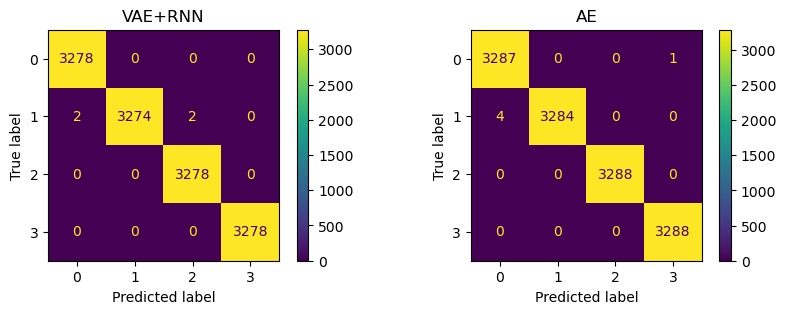

ROC Curve:


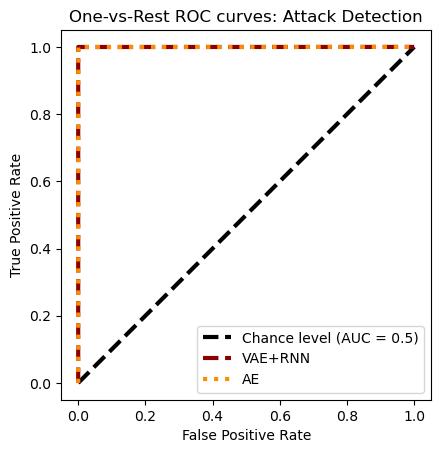

In [16]:
severity = 5
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.968962  1.000000  0.984237      3278
           1   1.000000  0.967968  0.983723      3278
           2   1.000000  0.995424  0.997707      3278
           3   0.995445  1.000000  0.997717      3278

    accuracy                       0.990848     13112
   macro avg   0.991102  0.990848  0.990846     13112
weighted avg   0.991102  0.990848  0.990846     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.977983  0.999696  0.988720      3288
           1   1.000000  0.999392  0.999696      3288
           2   1.000000  1.000000  1.000000      3288
           3   0.999689  0.978102  0.988778      3288

    accuracy                       0.994297     13152
   macro avg   0.994418  0.994297  0.994298     13152
weighted avg   0.994418  0.994297  0.994298     13152

Confusion Matrix:


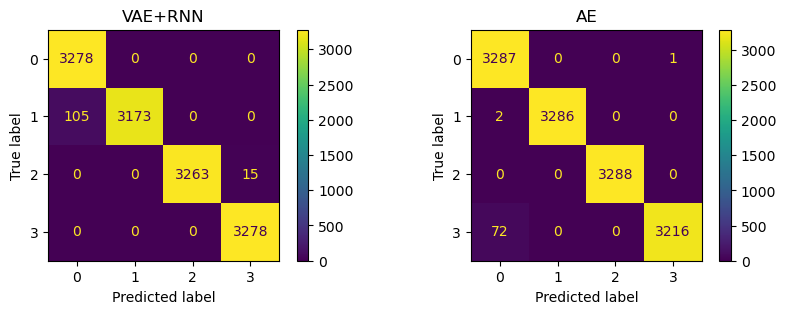

ROC Curve:


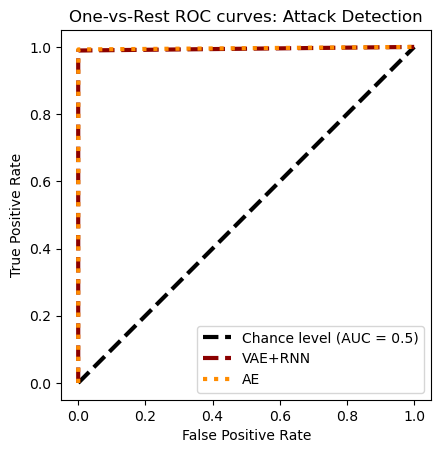

In [17]:
severity = 6
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.466952  1.000000  0.636628      3278
           1   1.000000  0.243441  0.391560      3278
           2   1.000000  0.742221  0.852040      3278
           3   0.704649  0.615009  0.656784      3278

    accuracy                       0.650168     13112
   macro avg   0.792900  0.650168  0.634253     13112
weighted avg   0.792900  0.650168  0.634253     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.337925  0.999696  0.505109      3288
           1   1.000000  0.015511  0.030548      3288
           2   1.000000  0.937348  0.967661      3288
           3   0.982877  0.087287  0.160335      3288

    accuracy                       0.509960     13152
   macro avg   0.830201  0.509960  0.415913     13152
weighted avg   0.830201  0.509960  0.415913     13152

Confusion Matrix:


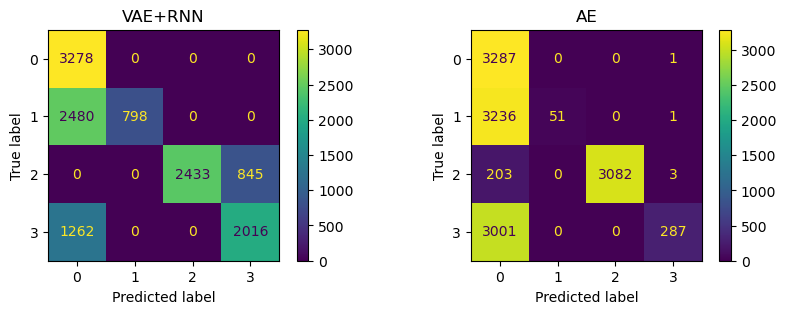

ROC Curve:


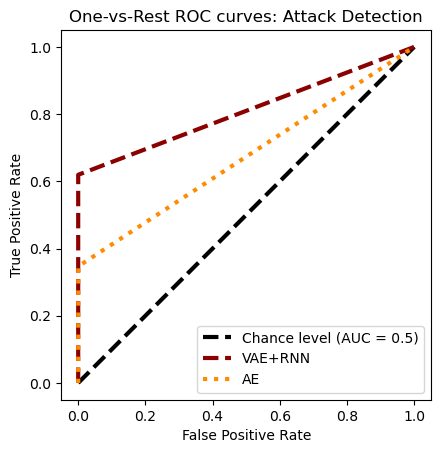

In [18]:
severity = 7
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.333435  1.000000  0.500114      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.006705  0.006711  0.006708      3278

    accuracy                       0.251678     13112
   macro avg   0.085035  0.251678  0.126706     13112
weighted avg   0.085035  0.251678  0.126706     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.250362  0.999696  0.400439      3288
           1   0.000000  0.000000  0.000000      3288
           2   0.000000  0.000000  0.000000      3288
           3   0.391304  0.002737  0.005436      3288

    accuracy                       0.250608     13152
   macro avg   0.160417  0.250608  0.101469     13152
weighted avg   0.160417  0.250608  0.101469     13152

Confusion Matrix:


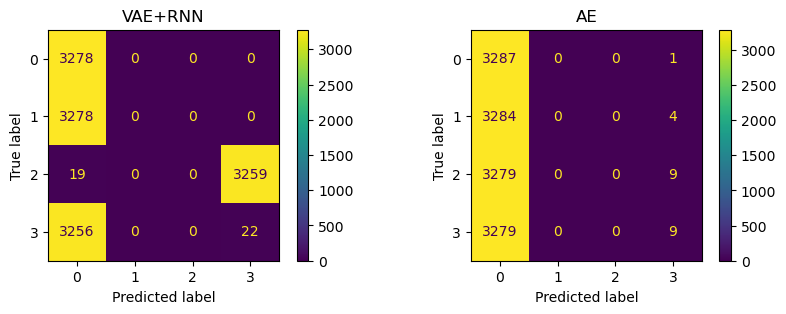

ROC Curve:


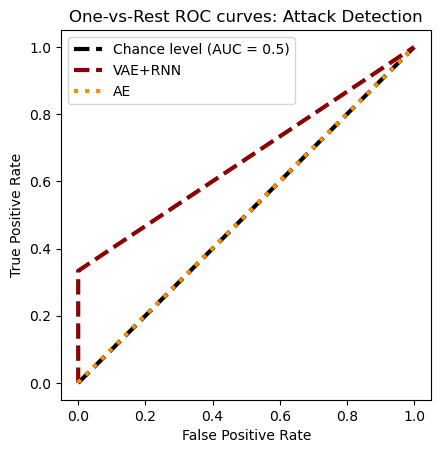

In [19]:
severity = 8
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250325  1.000000  0.400415      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.000000  0.000000  0.000000      3278

    accuracy                       0.250000     13112
   macro avg   0.062581  0.250000  0.100104     13112
weighted avg   0.062581  0.250000  0.100104     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.250209  0.999696  0.400244      3288
           1   0.000000  0.000000  0.000000      3288
           2   0.000000  0.000000  0.000000      3288
           3   0.333333  0.001521  0.003028      3288

    accuracy                       0.250304     13152
   macro avg   0.145886  0.250304  0.100818     13152
weighted avg   0.145886  0.250304  0.100818     13152

Confusion Matrix:


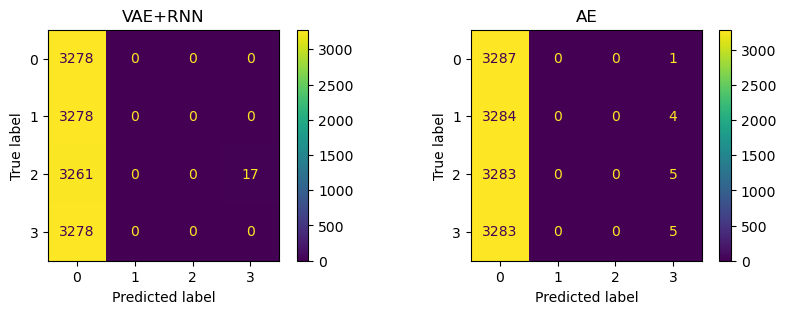

ROC Curve:


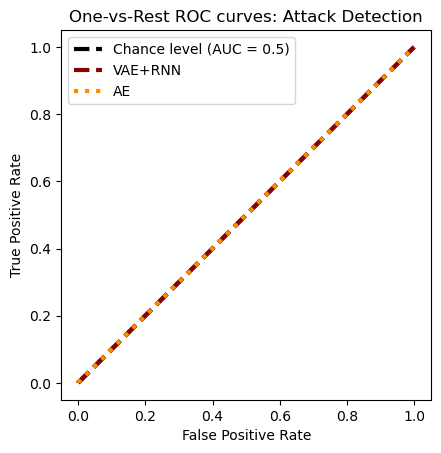

In [20]:
severity = 9
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 5%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999390  1.000000  0.999695      3278
           1   1.000000  0.998780  0.999389      3278
           2   0.999390  1.000000  0.999695      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999695     13112
   macro avg   0.999695  0.999695  0.999695     13112
weighted avg   0.999695  0.999695  0.999695     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.998785  0.999696  0.999240      3288
           1   1.000000  0.998783  0.999391      3288
           2   1.000000  1.000000  1.000000      3288
           3   0.999696  1.000000  0.999848      3288

    accuracy                       0.999620     13152
   macro avg   0.999620  0.999620  0.999620     13152
weighted avg   0.999620  0.999620  0.999620     13152

Confusion Matrix:


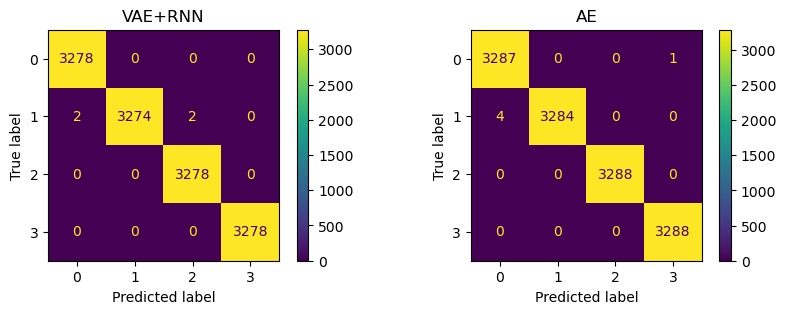

ROC Curve:


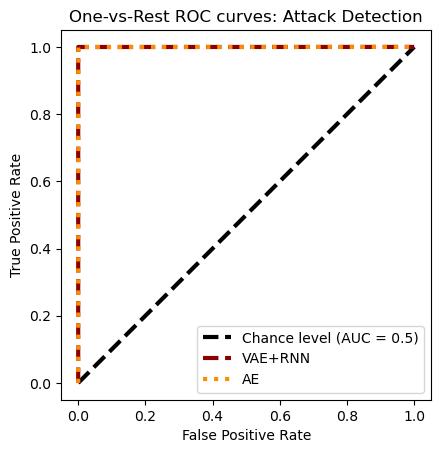

In [21]:
severity = 5
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.969822  1.000000  0.984680      3278
           1   1.000000  0.968883  0.984196      3278
           2   1.000000  0.996034  0.998013      3278
           3   0.996050  1.000000  0.998021      3278

    accuracy                       0.991229     13112
   macro avg   0.991468  0.991229  0.991228     13112
weighted avg   0.991468  0.991229  0.991228     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.954968  0.999696  0.976820      3288
           1   1.000000  0.992397  0.996184      3288
           2   1.000000  1.000000  1.000000      3288
           3   0.999683  0.960462  0.979680      3288

    accuracy                       0.988139     13152
   macro avg   0.988663  0.988139  0.988171     13152
weighted avg   0.988663  0.988139  0.988171     13152

Confusion Matrix:


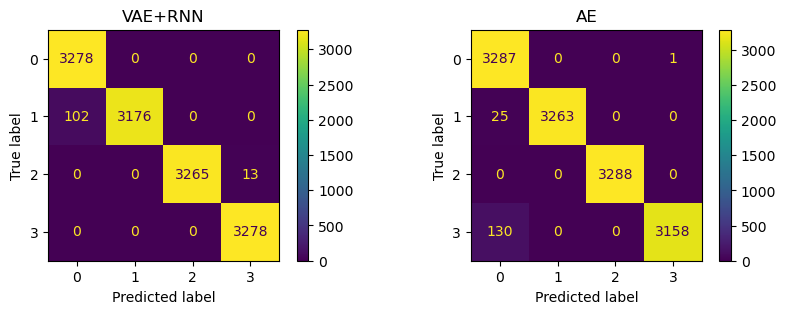

ROC Curve:


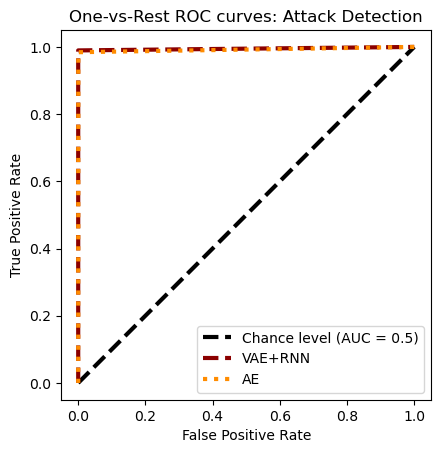

In [22]:
severity = 6
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.465890  1.000000  0.635641      3278
           1   1.000000  0.219036  0.359359      3278
           2   1.000000  0.726358  0.841491      3278
           3   0.698690  0.634533  0.665068      3278

    accuracy                       0.644982     13112
   macro avg   0.791145  0.644982  0.625390     13112
weighted avg   0.791145  0.644982  0.625390     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.376863  0.999696  0.547377      3288
           1   1.000000  0.141119  0.247335      3288
           2   1.000000  0.901460  0.948177      3288
           3   0.981038  0.298966  0.458275      3288

    accuracy                       0.585310     13152
   macro avg   0.839475  0.585310  0.550291     13152
weighted avg   0.839475  0.585310  0.550291     13152

Confusion Matrix:


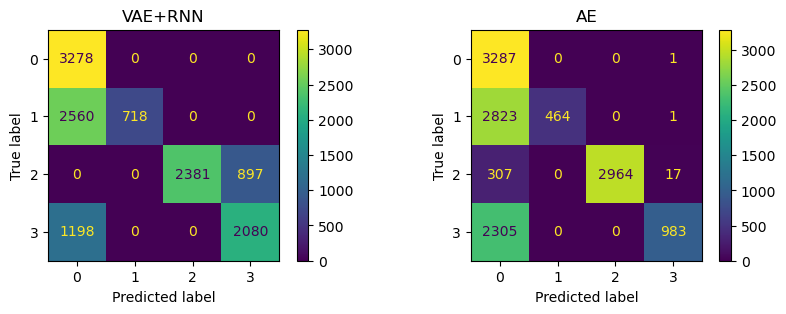

ROC Curve:


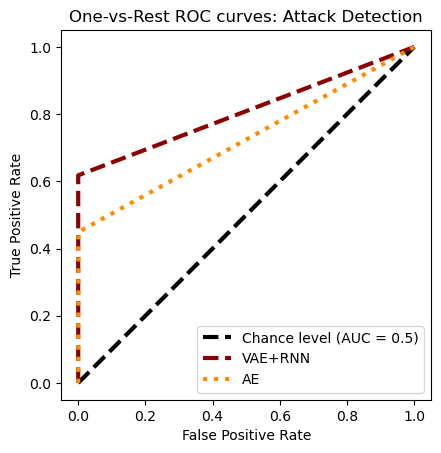

In [23]:
severity = 7
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.333401  1.000000  0.500076      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.007012  0.007016  0.007014      3278

    accuracy                       0.251754     13112
   macro avg   0.085103  0.251754  0.126773     13112
weighted avg   0.085103  0.251754  0.126773     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.255281  0.999696  0.406706      3288
           1   1.000000  0.002433  0.004854      3288
           2   1.000000  0.033759  0.065313      3288
           3   0.401274  0.019161  0.036575      3288

    accuracy                       0.263762     13152
   macro avg   0.664139  0.263762  0.128362     13152
weighted avg   0.664139  0.263762  0.128362     13152

Confusion Matrix:


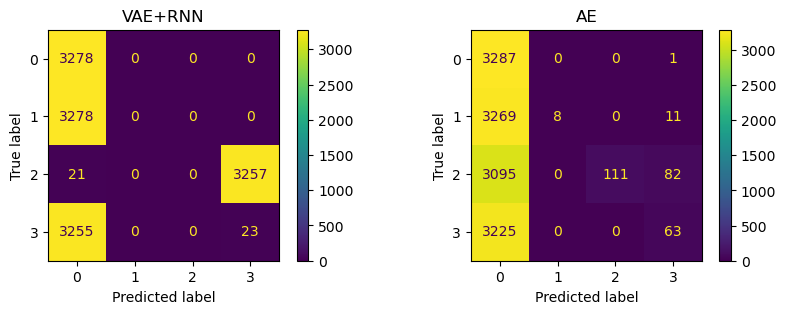

ROC Curve:


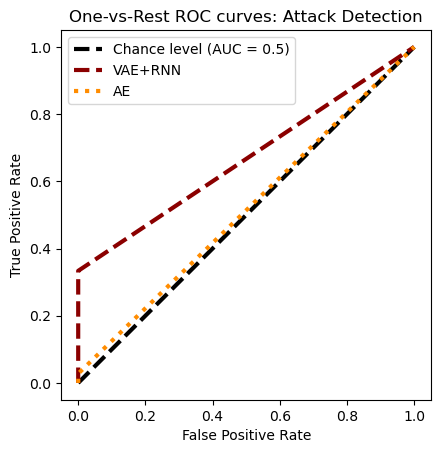

In [24]:
severity = 8
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250401  1.000000  0.400513      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.000000  0.000000  0.000000      3278

    accuracy                       0.250000     13112
   macro avg   0.062600  0.250000  0.100128     13112
weighted avg   0.062600  0.250000  0.100128     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.250514  0.999696  0.400634      3288
           1   1.000000  0.000304  0.000608      3288
           2   0.000000  0.000000  0.000000      3288
           3   0.266667  0.002433  0.004822      3288

    accuracy                       0.250608     13152
   macro avg   0.379295  0.250608  0.101516     13152
weighted avg   0.379295  0.250608  0.101516     13152

Confusion Matrix:


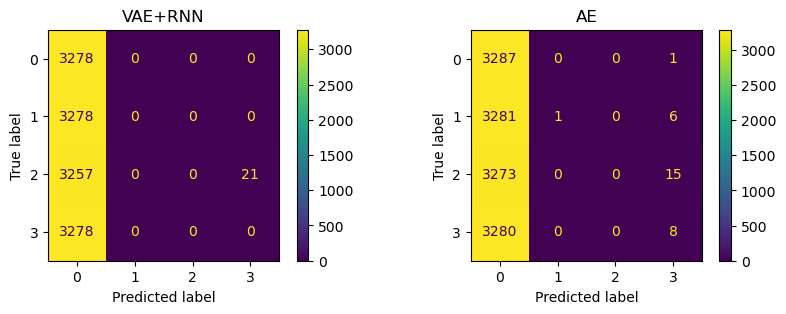

ROC Curve:


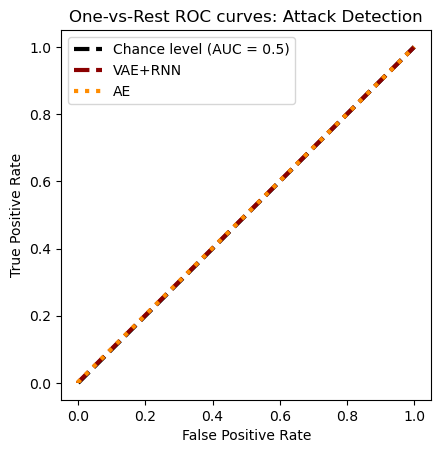

In [25]:
severity = 9
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 10%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999086  1.000000  0.999543      3278
           1   1.000000  0.998780  0.999389      3278
           2   0.999695  1.000000  0.999847      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999695     13112
   macro avg   0.999695  0.999695  0.999695     13112
weighted avg   0.999695  0.999695  0.999695     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.998785  1.000000  0.999392      3288
           1   1.000000  0.998783  0.999391      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  1.000000  1.000000      3288

    accuracy                       0.999696     13152
   macro avg   0.999696  0.999696  0.999696     13152
weighted avg   0.999696  0.999696  0.999696     13152

Confusion Matrix:


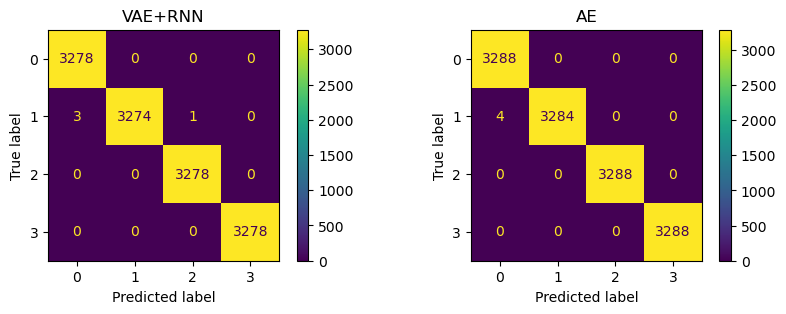

ROC Curve:


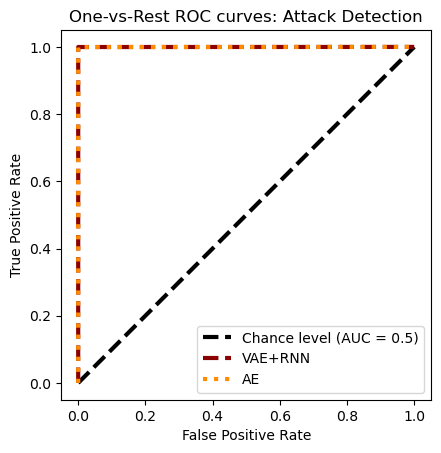

In [26]:
severity = 5
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.966107  1.000000  0.982761      3278
           1   1.000000  0.964918  0.982146      3278
           2   1.000000  0.995119  0.997554      3278
           3   0.995143  1.000000  0.997565      3278

    accuracy                       0.990009     13112
   macro avg   0.990312  0.990009  0.990006     13112
weighted avg   0.990312  0.990009  0.990006     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.920235  1.000000  0.958461      3288
           1   1.000000  0.998175  0.999087      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  0.915146  0.955693      3288

    accuracy                       0.978330     13152
   macro avg   0.980059  0.978330  0.978310     13152
weighted avg   0.980059  0.978330  0.978310     13152

Confusion Matrix:


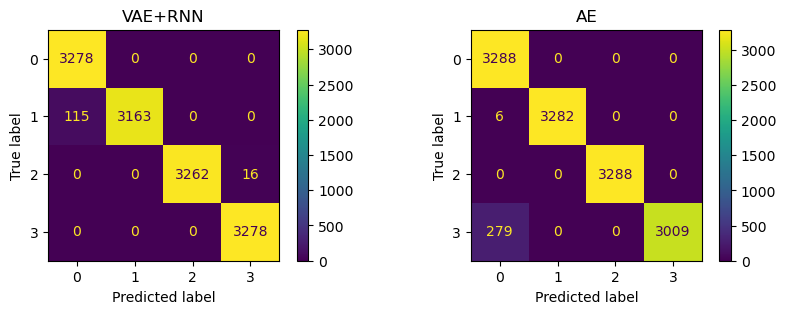

ROC Curve:


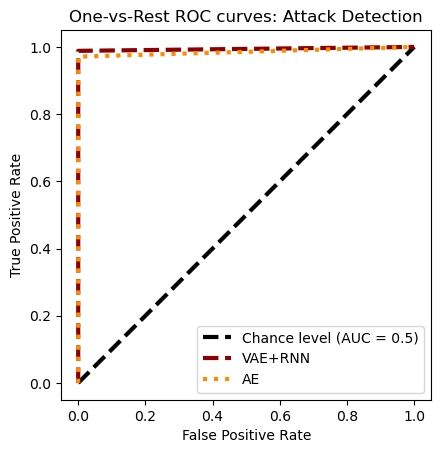

In [27]:
severity = 6
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.464965  1.000000  0.634779      3278
           1   1.000000  0.317877  0.482407      3278
           2   1.000000  0.768761  0.869265      3278
           3   0.696800  0.531422  0.602977      3278

    accuracy                       0.654515     13112
   macro avg   0.790441  0.654515  0.647357     13112
weighted avg   0.790441  0.654515  0.647357     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.332289  1.000000  0.498824      3288
           1   1.000000  0.026764  0.052133      3288
           2   1.000000  0.834854  0.909995      3288
           3   0.978774  0.126217  0.223599      3288

    accuracy                       0.496959     13152
   macro avg   0.827766  0.496959  0.421138     13152
weighted avg   0.827766  0.496959  0.421138     13152

Confusion Matrix:


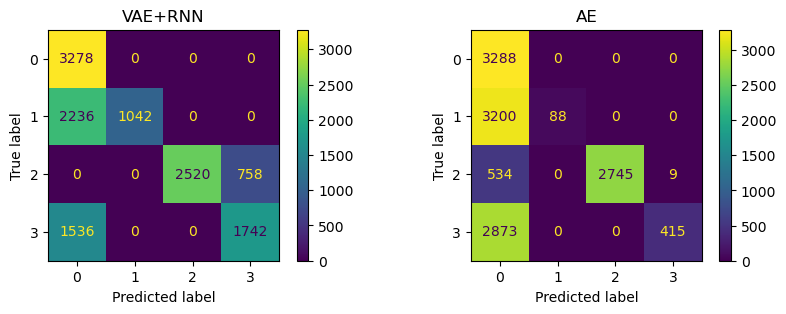

ROC Curve:


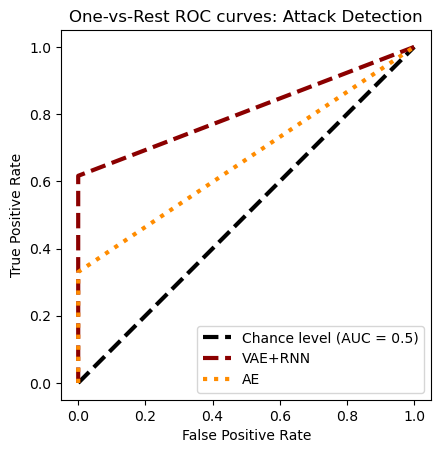

In [28]:
severity = 7
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.333435  1.000000  0.500114      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.005791  0.005796  0.005794      3278

    accuracy                       0.251449     13112
   macro avg   0.084806  0.251449  0.126477     13112
weighted avg   0.084806  0.251449  0.126477     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.251050  1.000000  0.401343      3288
           1   0.000000  0.000000  0.000000      3288
           2   1.000000  0.000608  0.001216      3288
           3   0.490566  0.007908  0.015564      3288

    accuracy                       0.252129     13152
   macro avg   0.435404  0.252129  0.104531     13152
weighted avg   0.435404  0.252129  0.104531     13152

Confusion Matrix:


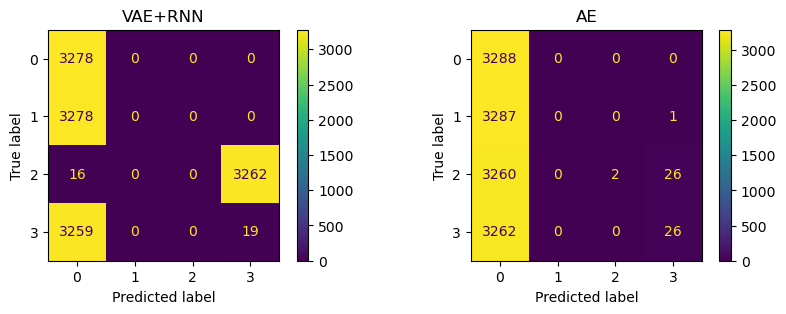

ROC Curve:


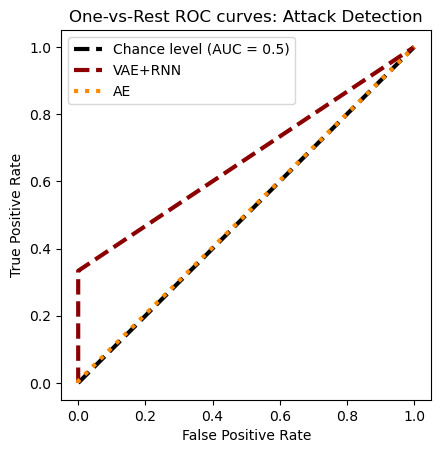

In [29]:
severity = 8
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250076  1.000000  0.400098      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.000000  0.000000  0.000000      3278

    accuracy                       0.250000     13112
   macro avg   0.062519  0.250000  0.100024     13112
weighted avg   0.062519  0.250000  0.100024     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.250228  1.000000  0.400292      3288
           1   0.000000  0.000000  0.000000      3288
           2   0.000000  0.000000  0.000000      3288
           3   0.500000  0.001825  0.003636      3288

    accuracy                       0.250456     13152
   macro avg   0.187557  0.250456  0.100982     13152
weighted avg   0.187557  0.250456  0.100982     13152

Confusion Matrix:


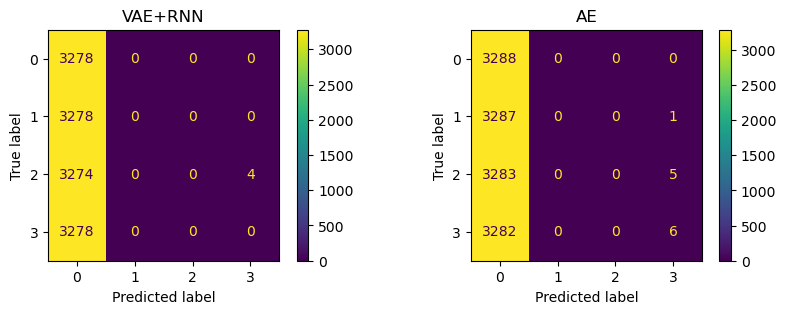

ROC Curve:


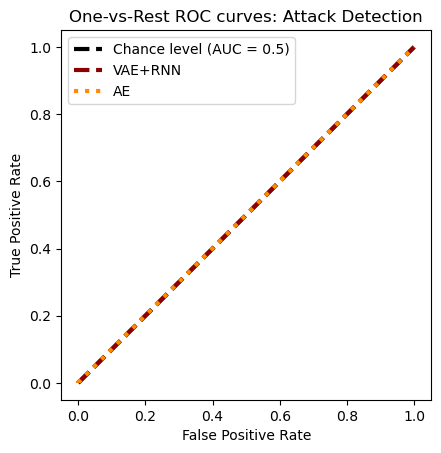

In [30]:
severity = 9
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 20%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999390  1.000000  0.999695      3278
           1   1.000000  0.998780  0.999389      3278
           2   0.999390  1.000000  0.999695      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999695     13112
   macro avg   0.999695  0.999695  0.999695     13112
weighted avg   0.999695  0.999695  0.999695     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.998785  0.999696  0.999240      3288
           1   1.000000  0.998783  0.999391      3288
           2   1.000000  1.000000  1.000000      3288
           3   0.999696  1.000000  0.999848      3288

    accuracy                       0.999620     13152
   macro avg   0.999620  0.999620  0.999620     13152
weighted avg   0.999620  0.999620  0.999620     13152

Confusion Matrix:


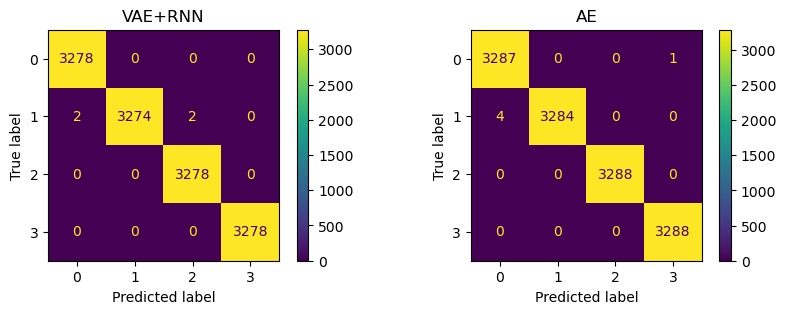

ROC Curve:


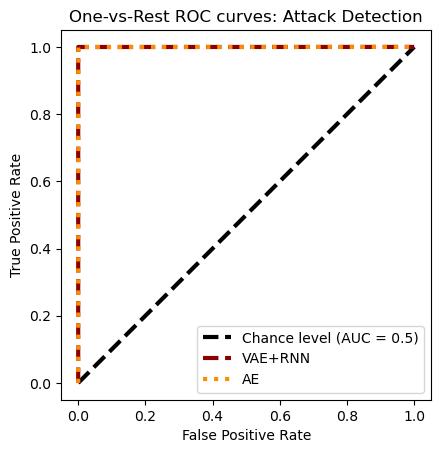

In [31]:
severity = 5
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.964401  1.000000  0.981878      3278
           1   1.000000  0.963087  0.981197      3278
           2   1.000000  0.995119  0.997554      3278
           3   0.995143  1.000000  0.997565      3278

    accuracy                       0.989552     13112
   macro avg   0.989886  0.989552  0.989548     13112
weighted avg   0.989886  0.989552  0.989548     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.976240  0.999696  0.987829      3288
           1   1.000000  1.000000  1.000000      3288
           2   1.000000  1.000000  1.000000      3288
           3   0.999688  0.975669  0.987533      3288

    accuracy                       0.993841     13152
   macro avg   0.993982  0.993841  0.993840     13152
weighted avg   0.993982  0.993841  0.993840     13152

Confusion Matrix:


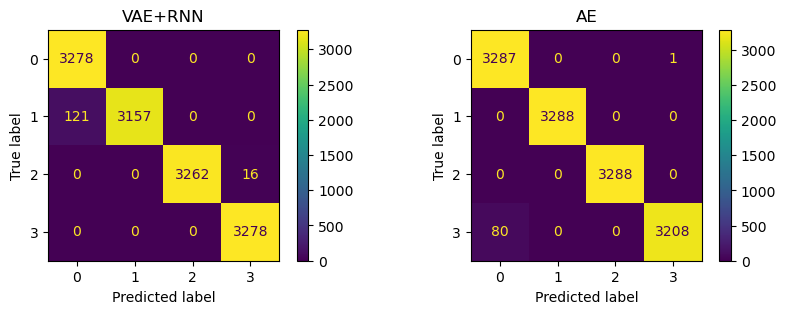

ROC Curve:


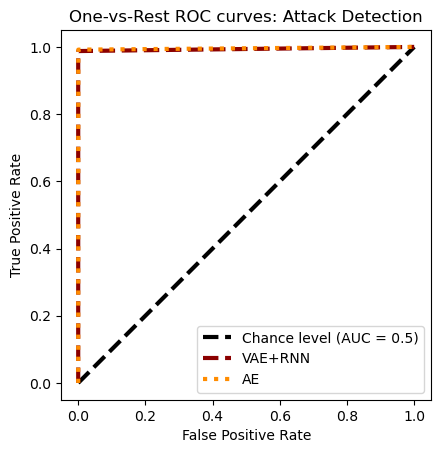

In [32]:
severity = 6
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.467351  1.000000  0.637000      3278
           1   1.000000  0.235204  0.380835      3278
           2   1.000000  0.717816  0.835731      3278
           3   0.688971  0.625076  0.655470      3278

    accuracy                       0.644524     13112
   macro avg   0.789081  0.644524  0.627259     13112
weighted avg   0.789081  0.644524  0.627259     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.331920  0.999696  0.498370      3288
           1   1.000000  0.001825  0.003643      3288
           2   1.000000  0.917883  0.957184      3288
           3   0.951111  0.065085  0.121833      3288

    accuracy                       0.496122     13152
   macro avg   0.820758  0.496122  0.395257     13152
weighted avg   0.820758  0.496122  0.395257     13152

Confusion Matrix:


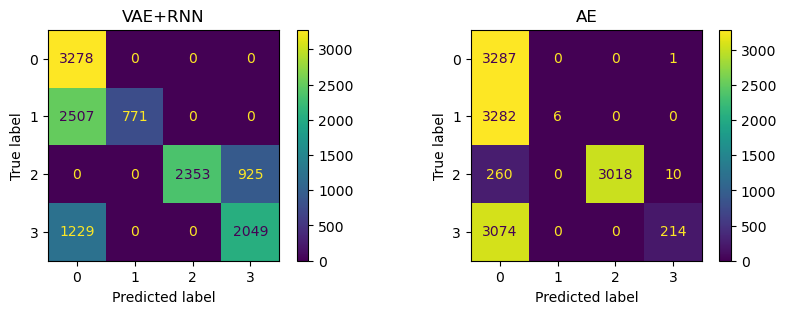

ROC Curve:


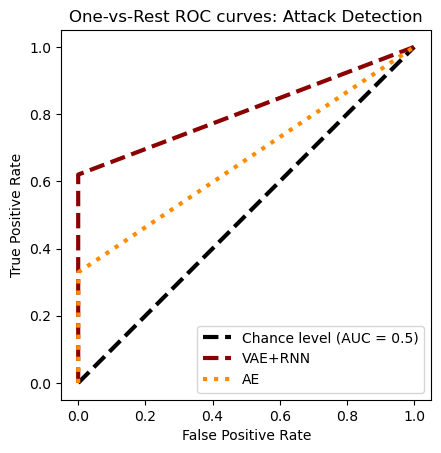

In [33]:
severity = 7
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.333469  1.000000  0.500153      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.007008  0.007016  0.007012      3278

    accuracy                       0.251754     13112
   macro avg   0.085119  0.251754  0.126791     13112
weighted avg   0.085119  0.251754  0.126791     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.250305  0.999696  0.400365      3288
           1   0.000000  0.000000  0.000000      3288
           2   0.000000  0.000000  0.000000      3288
           3   0.400000  0.002433  0.004837      3288

    accuracy                       0.250532     13152
   macro avg   0.162576  0.250532  0.101301     13152
weighted avg   0.162576  0.250532  0.101301     13152

Confusion Matrix:


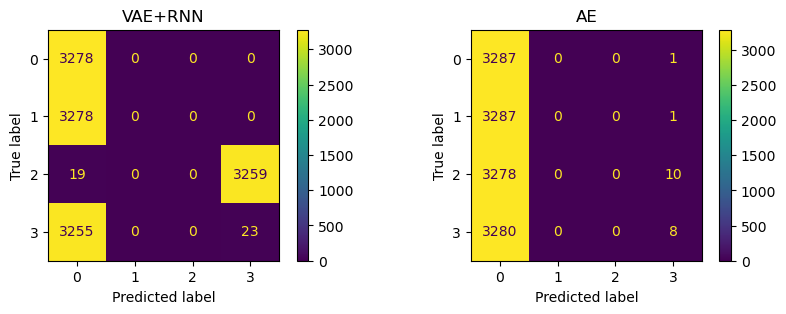

ROC Curve:


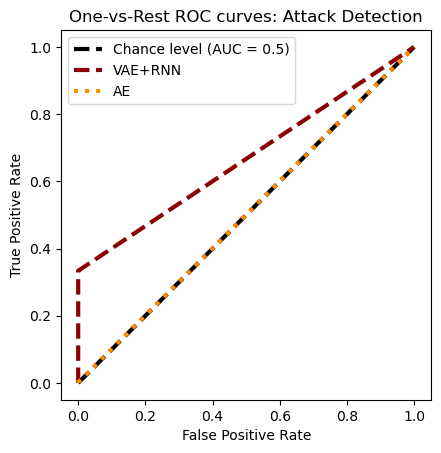

In [34]:
severity = 8
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250344  1.000000  0.400440      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.000000  0.000000  0.000000      3278

    accuracy                       0.250000     13112
   macro avg   0.062586  0.250000  0.100110     13112
weighted avg   0.062586  0.250000  0.100110     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.250038  0.999696  0.400024      3288
           1   0.000000  0.000000  0.000000      3288
           2   0.000000  0.000000  0.000000      3288
           3   0.333333  0.000608  0.001214      3288

    accuracy                       0.250076     13152
   macro avg   0.145843  0.250076  0.100310     13152
weighted avg   0.145843  0.250076  0.100310     13152

Confusion Matrix:


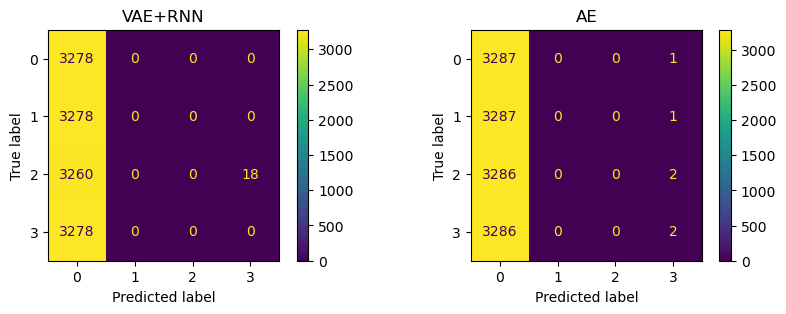

ROC Curve:


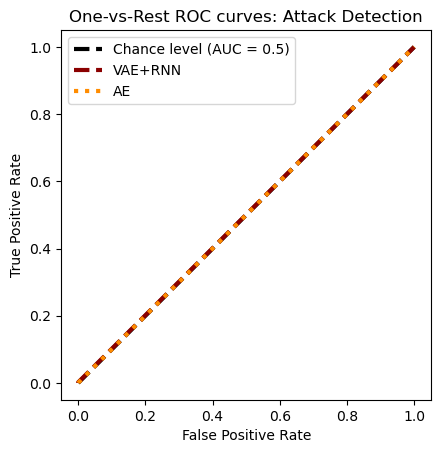

In [35]:
severity = 9
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 50%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.999695  1.000000  0.999847      3278
           1   1.000000  0.999085  0.999542      3278
           2   0.999390  1.000000  0.999695      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999771     13112
   macro avg   0.999771  0.999771  0.999771     13112
weighted avg   0.999771  0.999771  0.999771     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.998785  0.999696  0.999240      3288
           1   1.000000  0.998783  0.999391      3288
           2   1.000000  1.000000  1.000000      3288
           3   0.999696  1.000000  0.999848      3288

    accuracy                       0.999620     13152
   macro avg   0.999620  0.999620  0.999620     13152
weighted avg   0.999620  0.999620  0.999620     13152

Confusion Matrix:


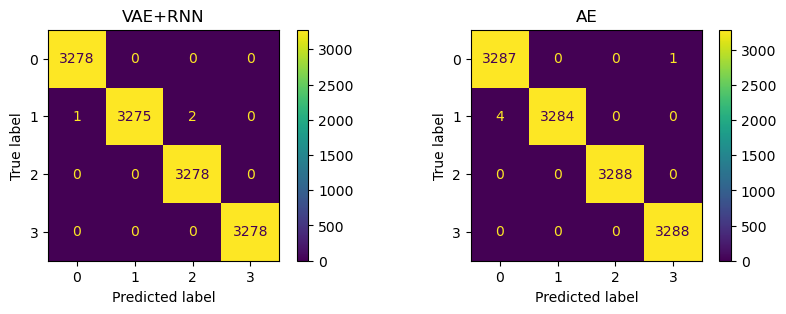

ROC Curve:


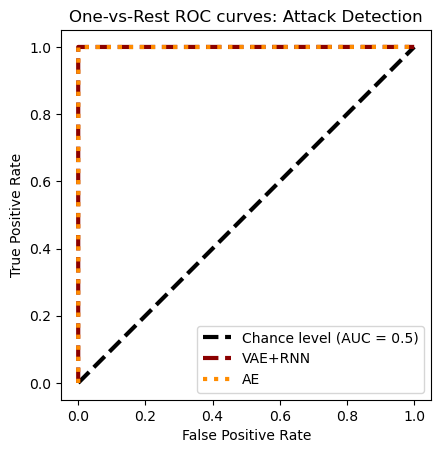

In [36]:
severity = 5
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.952630  1.000000  0.975740      3278
           1   1.000000  0.950275  0.974503      3278
           2   1.000000  0.994814  0.997400      3278
           3   0.994841  1.000000  0.997414      3278

    accuracy                       0.986272     13112
   macro avg   0.986868  0.986272  0.986264     13112
weighted avg   0.986868  0.986272  0.986264     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.977692  0.999696  0.988571      3288
           1   1.000000  0.991484  0.995724      3288
           2   1.000000  1.000000  1.000000      3288
           3   0.999692  0.985706  0.992649      3288

    accuracy                       0.994221     13152
   macro avg   0.994346  0.994221  0.994236     13152
weighted avg   0.994346  0.994221  0.994236     13152

Confusion Matrix:


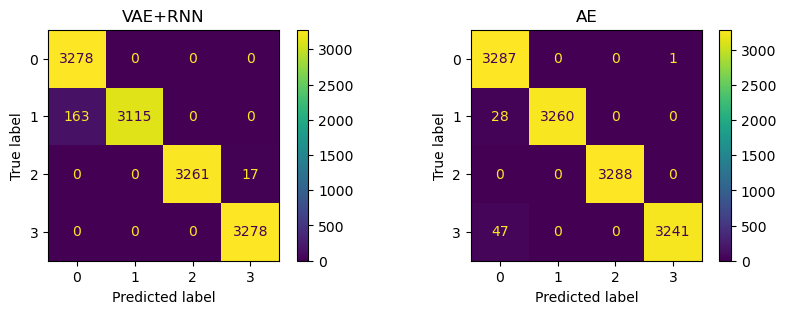

ROC Curve:


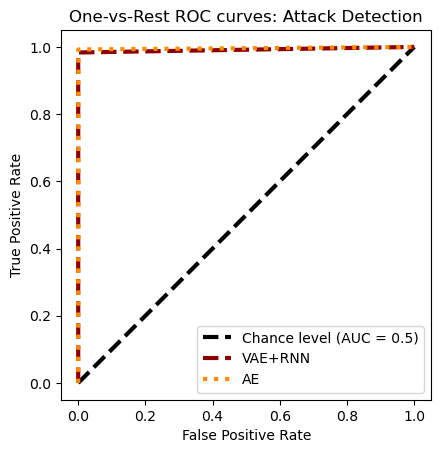

In [37]:
severity = 6
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.470436  1.000000  0.639859      3278
           1   1.000000  0.260525  0.413359      3278
           2   1.000000  0.739780  0.850430      3278
           3   0.702269  0.613789  0.655055      3278

    accuracy                       0.653523     13112
   macro avg   0.793176  0.653523  0.639676     13112
weighted avg   0.793176  0.653523  0.639676     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.332928  0.999696  0.499506      3288
           1   1.000000  0.000912  0.001823      3288
           2   1.000000  0.879866  0.936094      3288
           3   0.976501  0.113747  0.203759      3288

    accuracy                       0.498555     13152
   macro avg   0.827357  0.498555  0.410296     13152
weighted avg   0.827357  0.498555  0.410296     13152

Confusion Matrix:


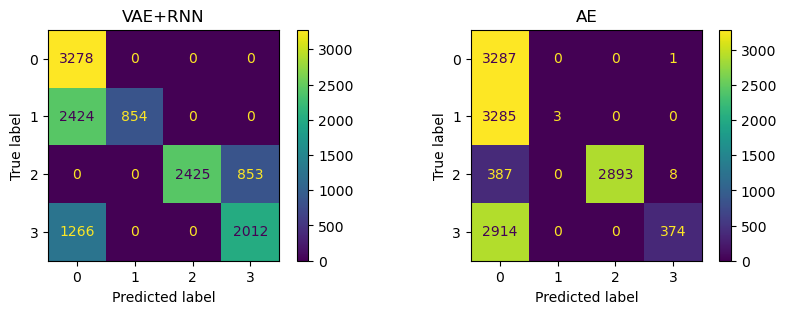

ROC Curve:


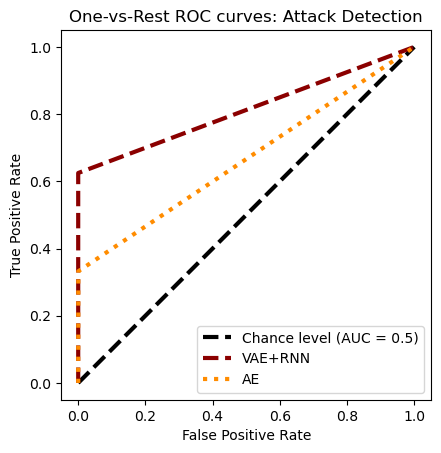

In [38]:
severity = 7
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.333707  1.000000  0.500420      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.009425  0.009457  0.009441      3278

    accuracy                       0.252364     13112
   macro avg   0.085783  0.252364  0.127465     13112
weighted avg   0.085783  0.252364  0.127465     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.250190  0.999696  0.400219      3288
           1   0.000000  0.000000  0.000000      3288
           2   0.000000  0.000000  0.000000      3288
           3   0.428571  0.001825  0.003634      3288

    accuracy                       0.250380     13152
   macro avg   0.169690  0.250380  0.100963     13152
weighted avg   0.169690  0.250380  0.100963     13152

Confusion Matrix:


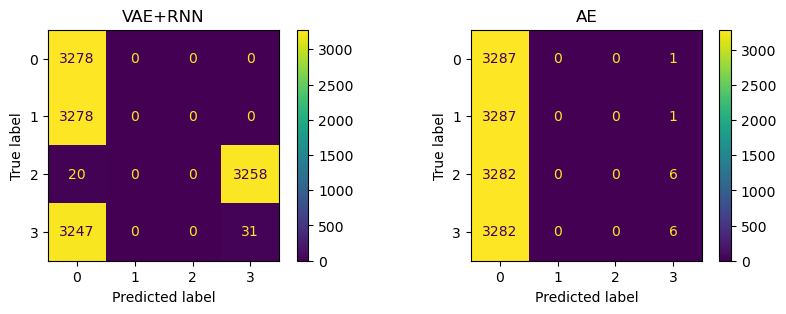

ROC Curve:


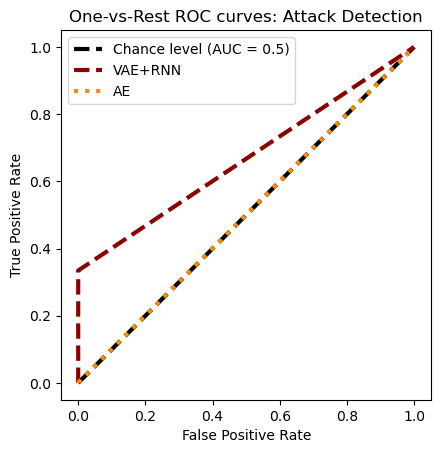

In [39]:
severity = 8
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.250363  1.000000  0.400464      3278
           1   0.000000  0.000000  0.000000      3278
           2   0.000000  0.000000  0.000000      3278
           3   0.000000  0.000000  0.000000      3278

    accuracy                       0.250000     13112
   macro avg   0.062591  0.250000  0.100116     13112
weighted avg   0.062591  0.250000  0.100116     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.249981  0.999696  0.399951      3288
           1   0.000000  0.000000  0.000000      3288
           2   0.000000  0.000000  0.000000      3288
           3   0.333333  0.000304  0.000608      3288

    accuracy                       0.250000     13152
   macro avg   0.145829  0.250000  0.100140     13152
weighted avg   0.145829  0.250000  0.100140     13152

Confusion Matrix:


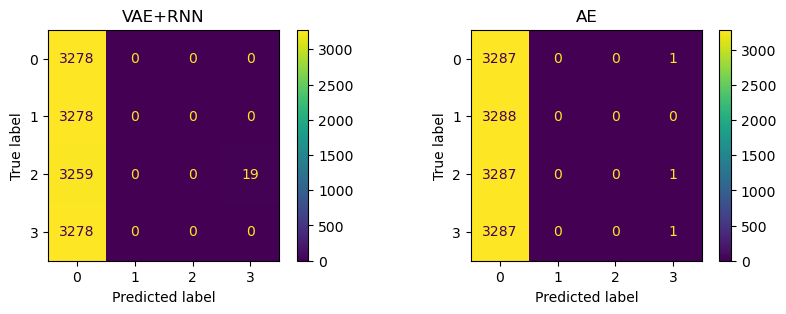

ROC Curve:


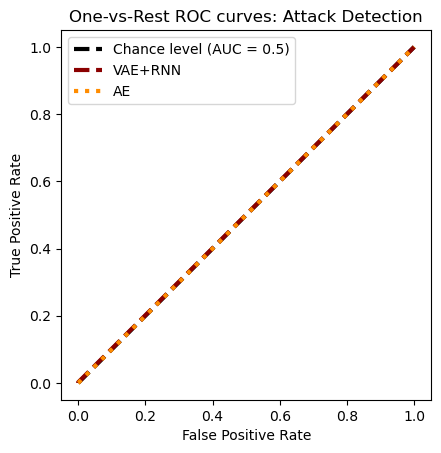

In [40]:
severity = 9
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

## **Quantiles**

In [41]:
q = torch.tensor([0.025, 0.975])
x_ax = ['0%', '%5', '%10', '%20', '50%']

### **Quantiles: Attack Severity 5**

In [44]:
severity = 5
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
mode, _min, _max = defaultdict(dict), defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                mode[k][kk[0],_type] = _pred.mode(dim=0)[0].numpy()[_type]
                _low, _up = torch.nanquantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 27.06it/s]


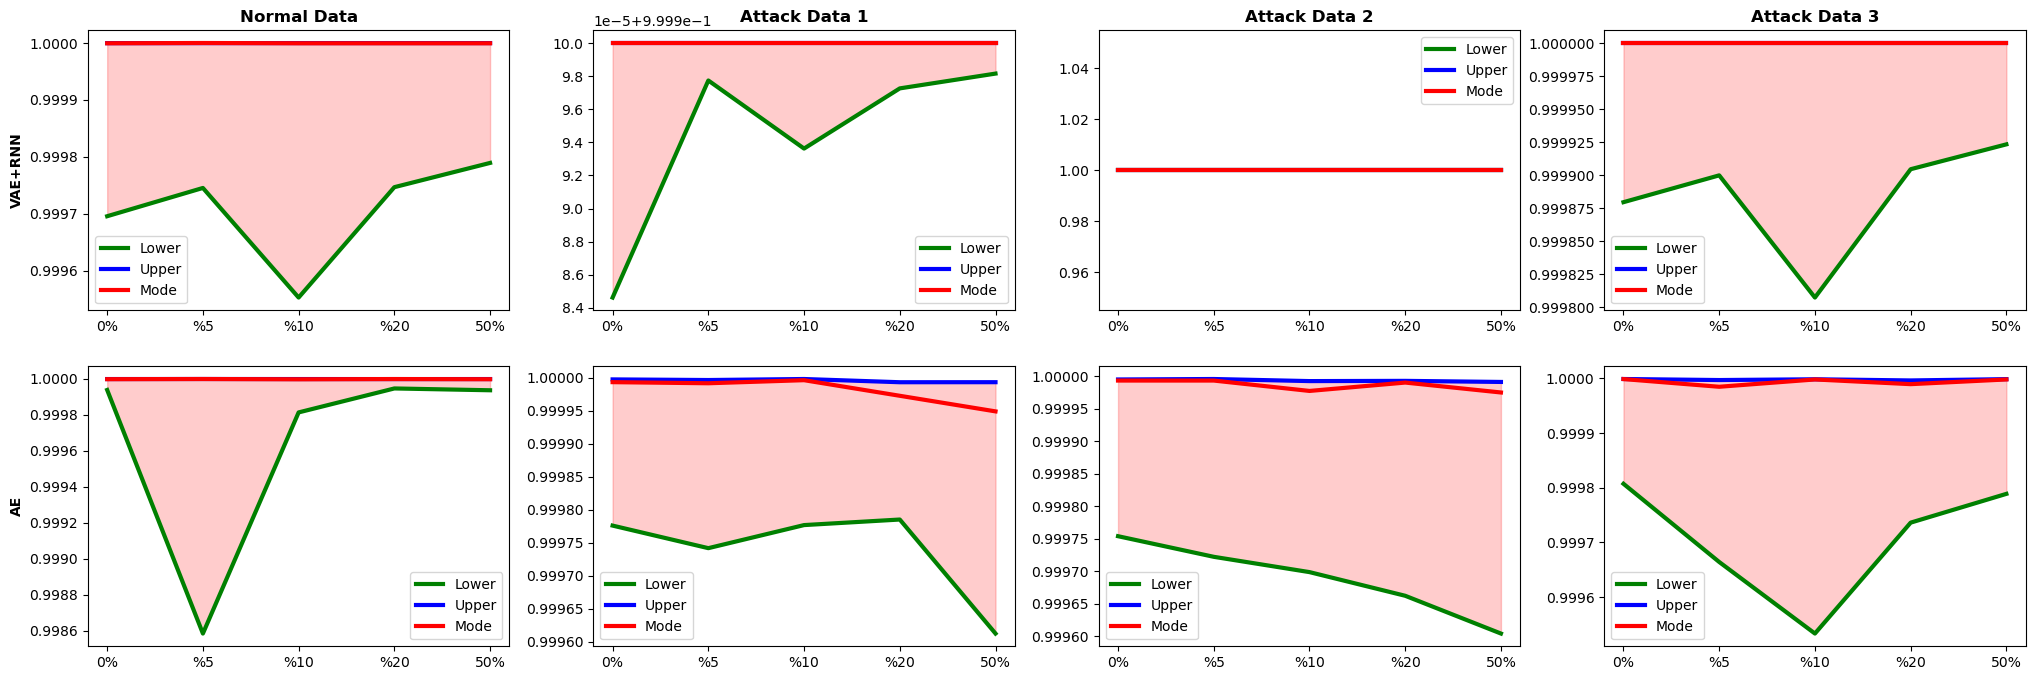

In [45]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mode[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mode', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.show()

### **Quantiles: Attack Severity 6**

In [46]:
severity = 6
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
mode, _min, _max = defaultdict(dict), defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                mode[k][kk[0],_type] = _pred.mode(dim=0)[0].numpy()[_type]
                _low, _up = torch.nanquantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 31.13it/s]


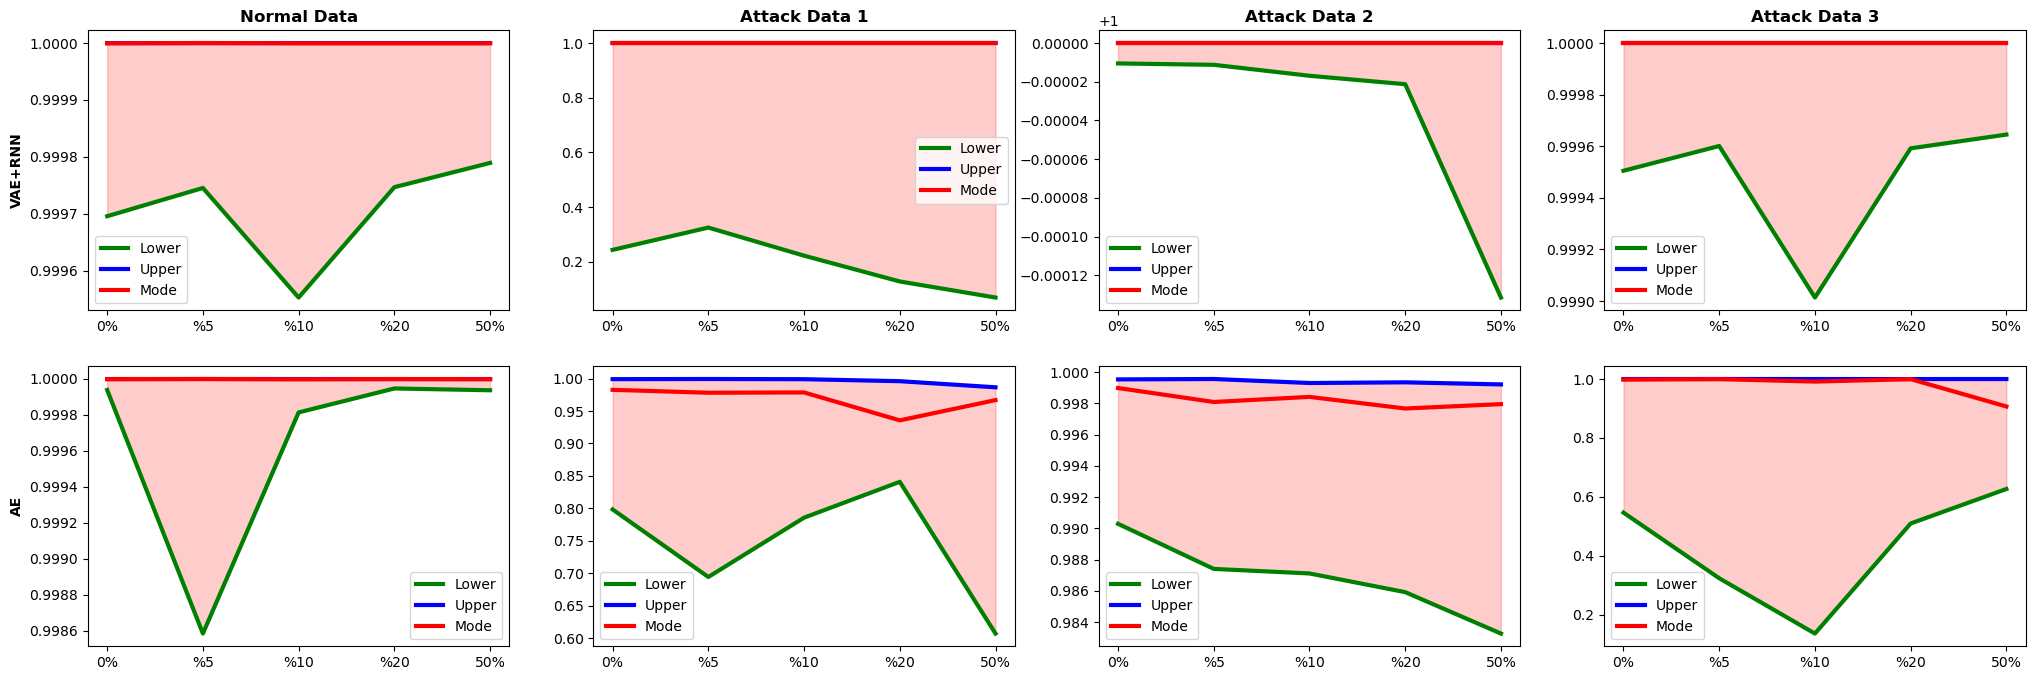

In [48]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mode[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mode', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.show()

### **Quantiles: Attack Severity 7**

In [49]:
severity = 7
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
mode, _min, _max = defaultdict(dict), defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                mode[k][kk[0],_type] = _pred.mode(dim=0)[0].numpy()[_type]
                _low, _up = torch.nanquantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00,  7.31it/s]


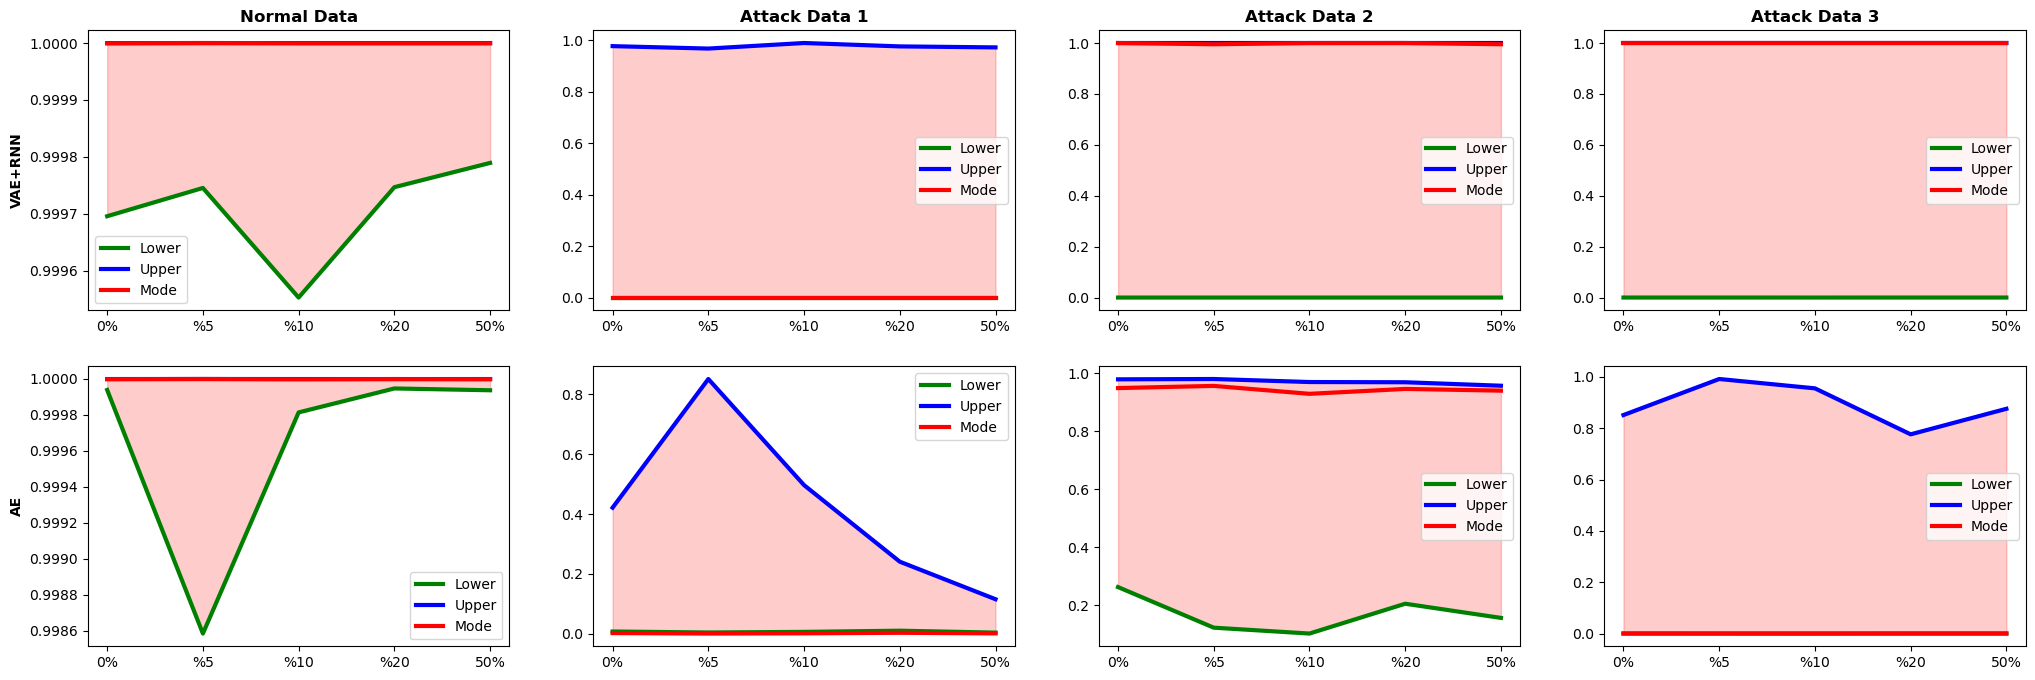

In [50]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mode[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mode', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.show()

### **Quantiles: Attack Severity 8**

In [52]:
severity = 8
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
mode, _min, _max = defaultdict(dict), defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                mode[k][kk[0],_type] = _pred.mode(dim=0)[0].numpy()[_type]
                _low, _up = torch.nanquantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 30.11it/s]


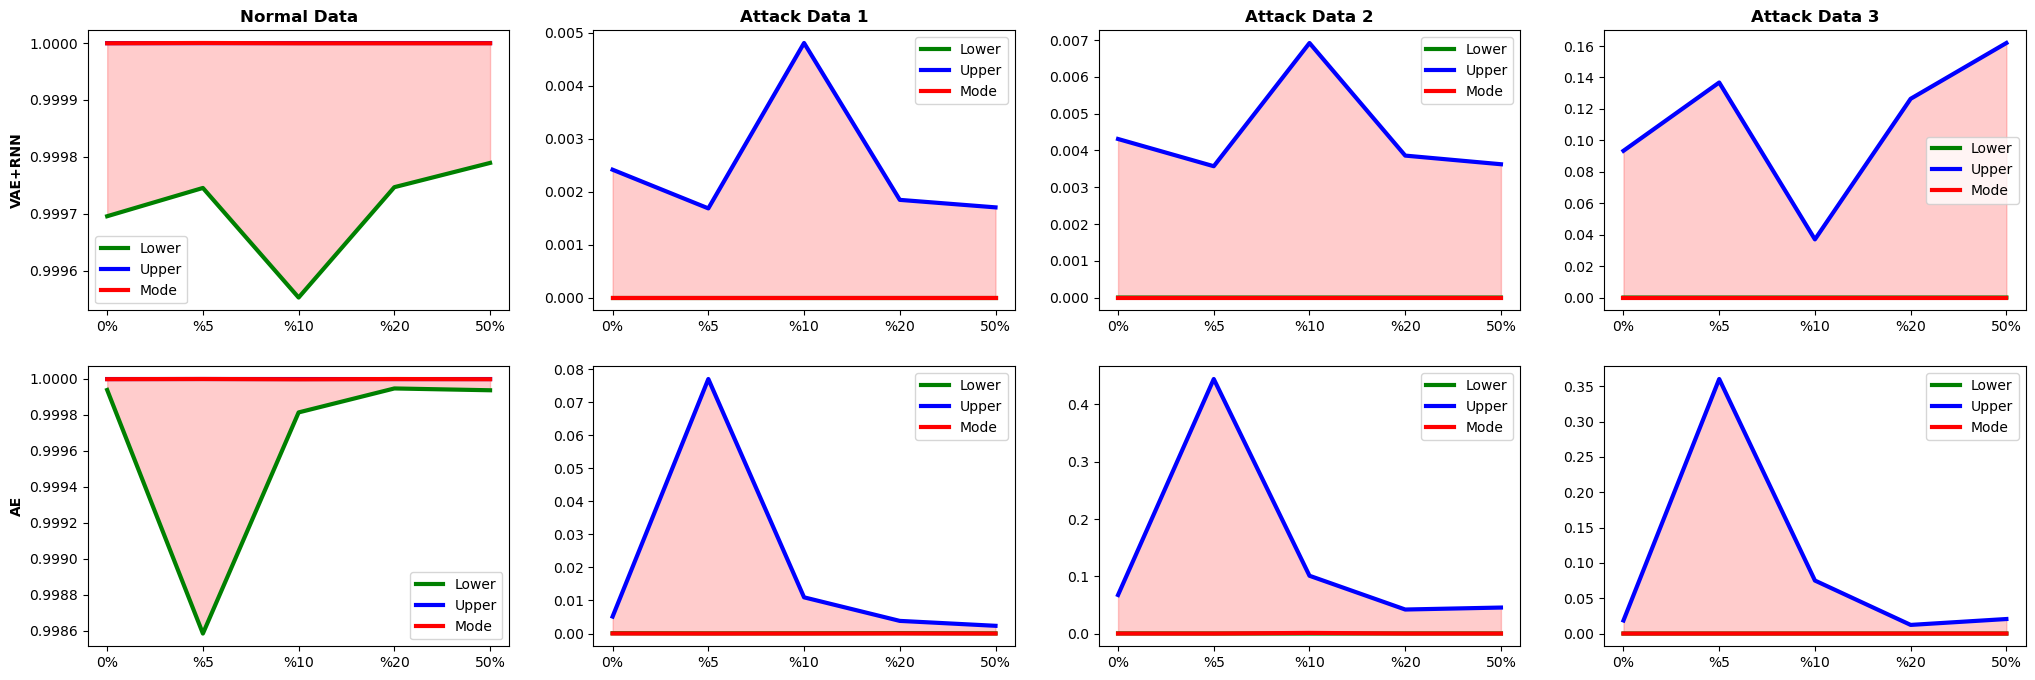

In [53]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mode[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mode', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.show()

### **Quantiles: Attack Severity 9**

In [54]:
severity = 9
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
mode, _min, _max = defaultdict(dict), defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                mode[k][kk[0],_type] = _pred.mode(dim=0)[0].numpy()[_type]
                _low, _up = torch.nanquantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 17.48it/s]


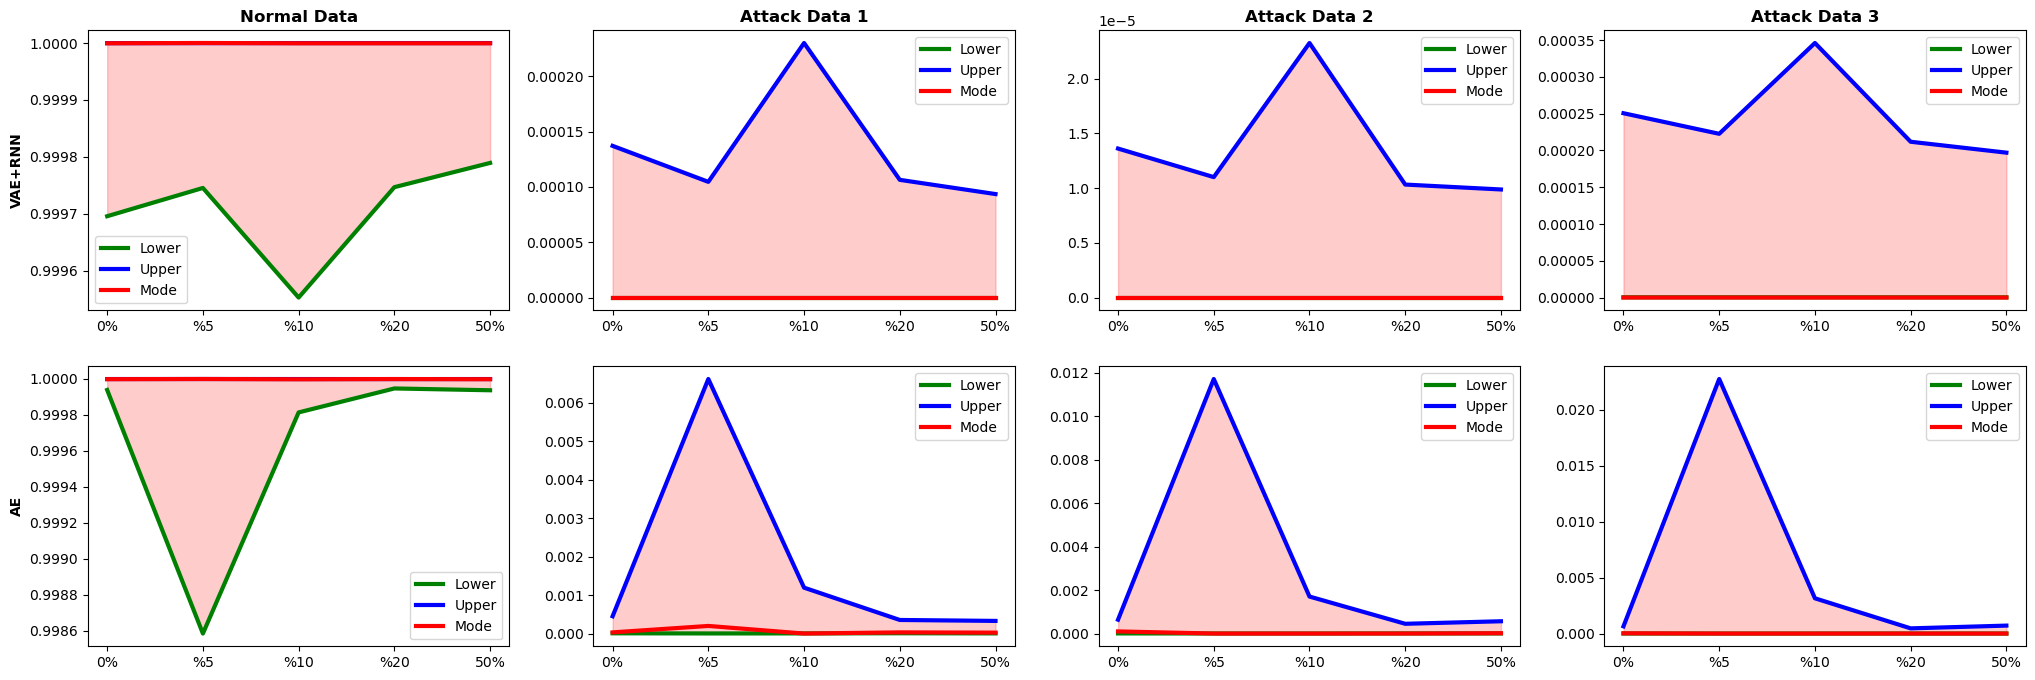

In [55]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mode[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mode', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.show()

## **Detection-Localozation Accuracy**

In [56]:
detection, localization = defaultdict(list), defaultdict(list)
for k in pred.keys():
    for severity in range(5,10):
        for level in noise_levels:
            pp = torch.argmax(pred[k][level,severity], dim=1).numpy()
            yy = torch.argmax(y[k], dim=1).numpy()
            localization[k, severity].append(metrics.accuracy_score(yy, pp))
            yy[yy>0] = 1
            pp[pp>0] = 1
            detection[k, severity].append(metrics.accuracy_score(yy,pp))

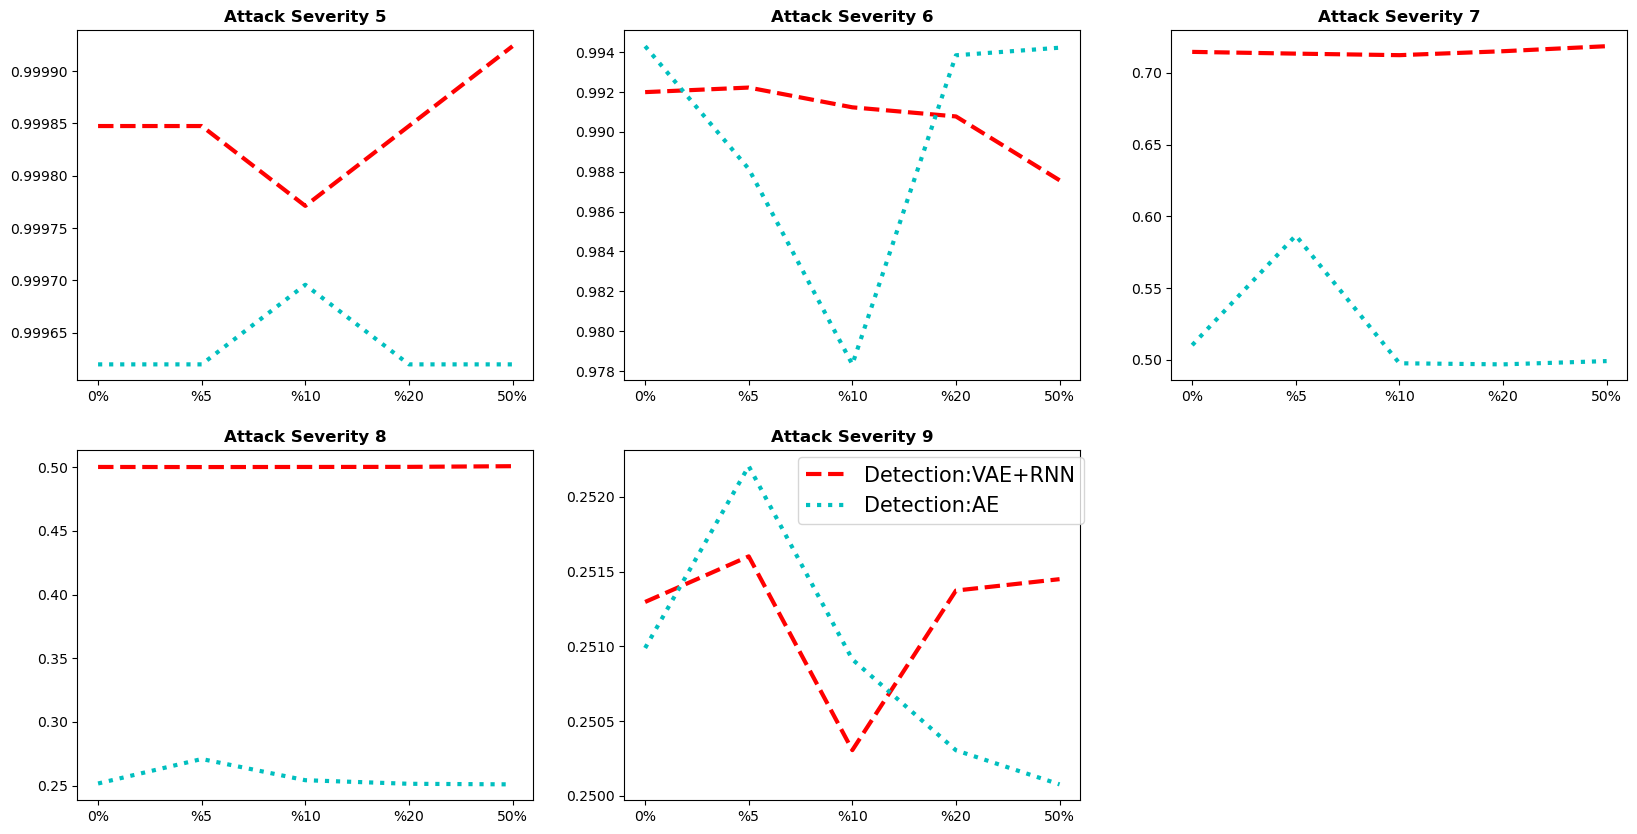

In [58]:
severity = list(range(5,10))
x = np.arange(len(noise_levels))
x_ax = ['0%', '%5', '%10', '%20', '50%']
fig, ax = plt.subplots(2,3, figsize=(20,10))
fig.delaxes(ax[1,2])
for s in severity:
    i = 0 if s < 8 else 1
    j = 0 if s < 8 else 3
    ax[i,s-5-j].plot(x, detection['vae',s], label='Detection:VAE+RNN', lw=3, linestyle="dashed", color='r')
    ax[i,s-5-j].plot(x, detection['ae',s], label='Detection:AE', lw=3, linestyle=':', color='c')
    ax[i,s-5-j].set(xticks=x, xticklabels=x_ax)
    ax[i,s-5-j].set_title(f'Attack Severity {s}', fontweight='bold')
ax[1,1].legend(prop={'size': 15}, bbox_to_anchor=(1.03, 1.01))
plt.show()

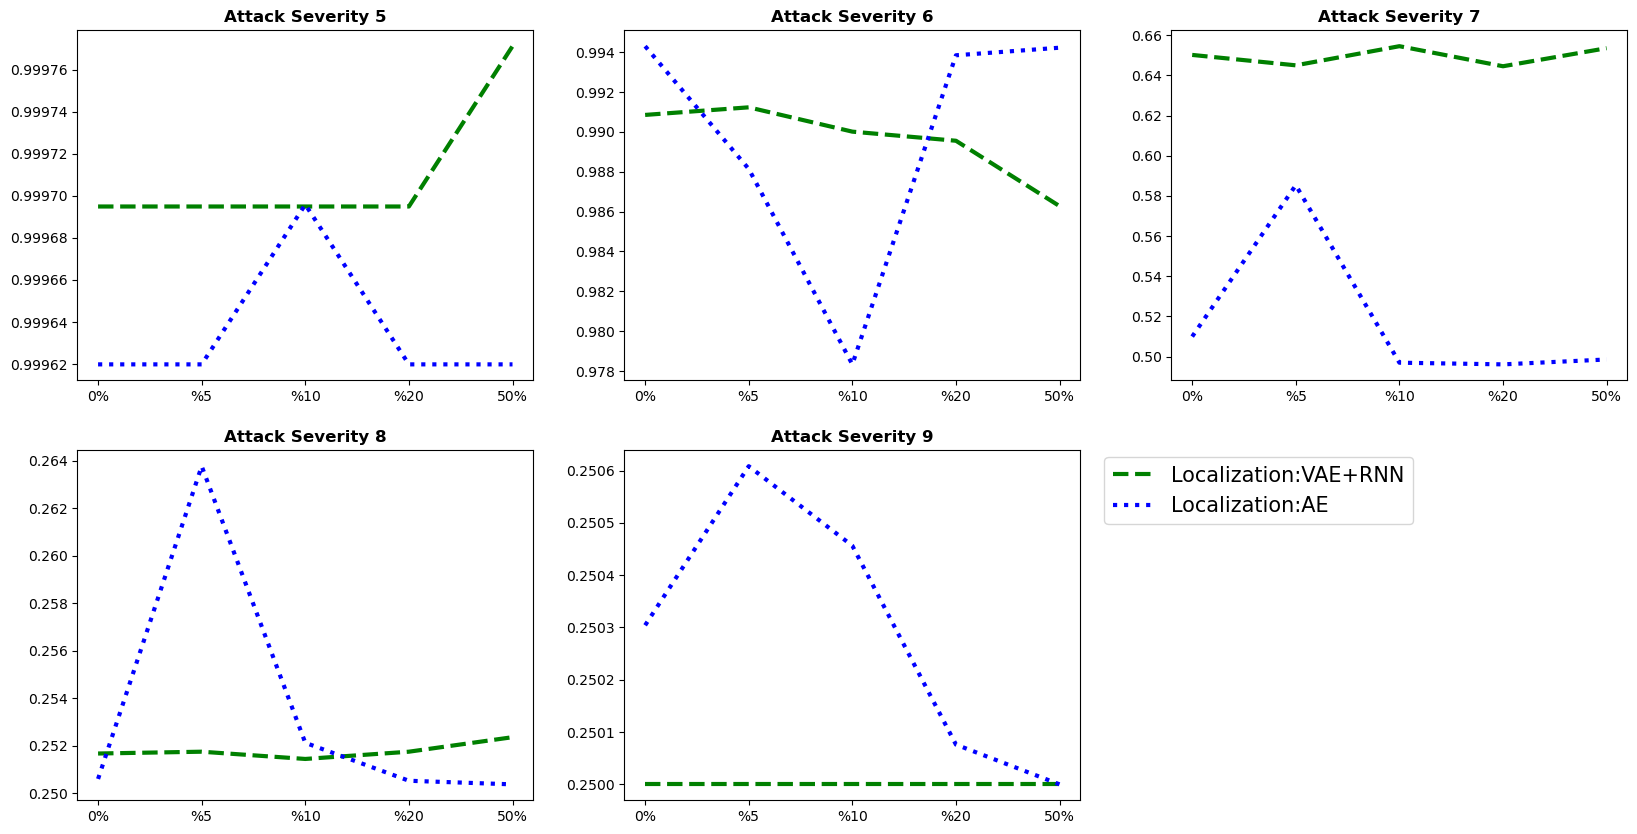

In [59]:
severity = list(range(5,10))
x = np.arange(len(noise_levels))
x_ax = ['0%', '%5', '%10', '%20', '50%']
fig, ax = plt.subplots(2,3, figsize=(20,10))
fig.delaxes(ax[1,2])
for s in severity:
    i = 0 if s < 8 else 1
    j = 0 if s < 8 else 3
    ax[i,s-5-j].plot(x, localization['vae',s], label='Localization:VAE+RNN', lw=3, linestyle="dashed", color='g')
    ax[i,s-5-j].plot(x, localization['ae',s], label='Localization:AE', lw=3, linestyle=':', color='b')
    ax[i,s-5-j].set(xticks=x, xticklabels=x_ax)
    ax[i,s-5-j].set_title(f'Attack Severity {s}', fontweight='bold')
ax[1,1].legend(prop={'size': 15}, bbox_to_anchor=(1.03, 1.01))
plt.show()